link to data https://www.kaggle.com/datasets/nikhilpandey360/chest-xray-masks-and-labels
or https://drive.google.com/drive/folders/1i3XnD-JdcPHqGQjHSBw6uaq4V_IzuRNt?usp=sharing


In [25]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import cv2
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2 as cv
import PIL
## checking for xrays and their respective masks
from glob import glob
import re
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
import cv2, ast
import torchvision
import matplotlib.pyplot as plt
from os.path import isfile
import torch.nn.init as init
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from PIL import Image, ImageFilter
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Dataset
from torchvision import transforms
from torch.optim import Adam, SGD, RMSprop
import time
from torch.autograd import Variable
import torch.functional as F
from tqdm import tqdm
from sklearn import metrics
import urllib
import pickle
#import cv2
import torch.nn.functional as F
from torchvision import models
import seaborn as sns
import random
#from apex import amp
import sys

In [27]:
from collections import defaultdict
import re

In [28]:
!kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels -p /content/dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/nikhilpandey360/chest-xray-masks-and-labels
License(s): CC0-1.0
100% 9.58G/9.58G [04:06<00:00, 43.7MB/s]
100% 9.58G/9.58G [04:06<00:00, 41.7MB/s]


In [29]:
lung_image_paths = glob(os.path.join("dataset/Lung Segmentation/CXR_png/*.png"))
mask_image_paths = glob(os.path.join("dataset/Lung Segmentation/masks/*.png"))

related_paths = defaultdict(list)

for img_path in lung_image_paths:
    img_match = re.search("CXR_png/(.*)\.png$", img_path)
    if img_match:
        img_name = img_match.group(1)
    for mask_path in mask_image_paths:
        mask_match = re.search(img_name, mask_path)
        if mask_match:
            related_paths["image_path"].append(img_path)
            related_paths["mask_path"].append(mask_path)

paths_df = pd.DataFrame.from_dict(related_paths)

In [30]:
print(lung_image_paths[:5])


['dataset/Lung Segmentation/CXR_png/CHNCXR_0423_1.png', 'dataset/Lung Segmentation/CXR_png/CHNCXR_0265_0.png', 'dataset/Lung Segmentation/CXR_png/MCUCXR_0367_1.png', 'dataset/Lung Segmentation/CXR_png/CHNCXR_0471_1.png', 'dataset/Lung Segmentation/CXR_png/CHNCXR_0172_0.png']


In [31]:
print(related_paths.keys())


dict_keys(['image_path', 'mask_path'])


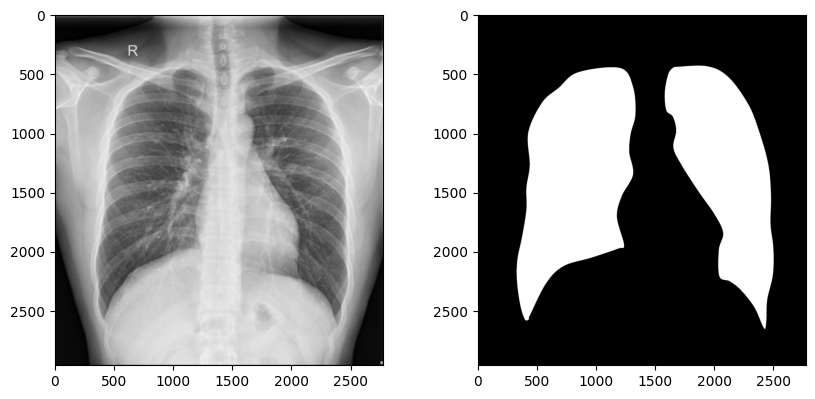

In [32]:
xray_num = 5
img_path = paths_df["image_path"][xray_num]
mask_path = paths_df["mask_path"][xray_num]

img = PIL.Image.open(img_path)
mask = PIL.Image.open(mask_path)

fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img, cmap = "gray")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(mask, cmap = "gray")

In [33]:
from tqdm import tqdm
import cv2
def prepare_train_test(df = pd.DataFrame(), resize_shape = tuple(), color_mode = "rgb"):
    img_array = list()
    mask_array = list()

    for image_path in tqdm(paths_df.image_path):
        resized_image = cv2.resize(cv2.imread(image_path),resize_shape)
        resized_image = resized_image/255.
        if color_mode == "gray":
            img_array.append(resized_image[:,:,0])
        elif color_mode == "rgb":
            img_array.append(resized_image[:,:,:])
      # img_array.append(resized_image)

    for mask_path in tqdm(paths_df.mask_path):
        resized_mask = cv2.resize(cv2.imread(mask_path),resize_shape)
        resized_mask = resized_mask/255.
        mask_array.append(resized_mask[:,:,0])
        # mask_array.append(resized_image)

    return img_array, mask_array

img_array, mask_array = prepare_train_test(df = paths_df, resize_shape = (224,224), color_mode = "gray")

100%|██████████| 704/704 [00:49<00:00, 14.33it/s]


In [34]:
704/100*80

563.2

In [35]:
X_train, X_test = img_array[:563], img_array[563:]
y_train, y_test = mask_array[:563], mask_array[563:]

In [36]:
len(X_train) + len(X_test)

704

In [37]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
class MyDataset(Dataset):
    def __init__(self, data, targets, transform):
        self.data = data
        self.targets = targets
        self.transforms = transform

    def __getitem__(self, index):
      x = self.data[index]
      y = self.targets[index]
      if self.transforms:
          # Apply the transform separately to each input
          x = self.transforms(x)
          y = self.transforms(y)
      return x, y


    def __len__(self):
        return len(self.data)
%matplotlib inline

In [38]:
import torchvision.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
#     if train:
#         transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [39]:

dataset = MyDataset(X_train,y_train, get_transform(True))
train_loader = DataLoader(dataset, batch_size=4)

testset = MyDataset(X_test,y_test, get_transform(True))
val_loader = DataLoader(testset, batch_size=4)

In [40]:
import tqdm
for img,target in tqdm.tqdm(train_loader):
    z = 1

100%|██████████| 141/141 [00:00<00:00, 500.54it/s]


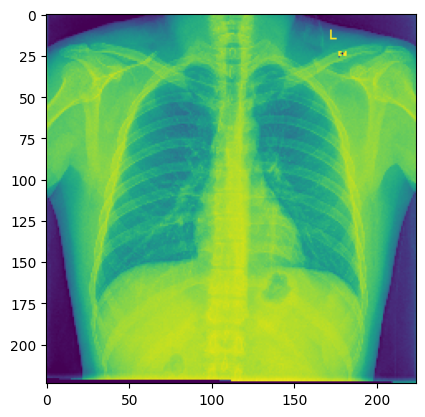

In [41]:
plt.imshow(img[0][0])

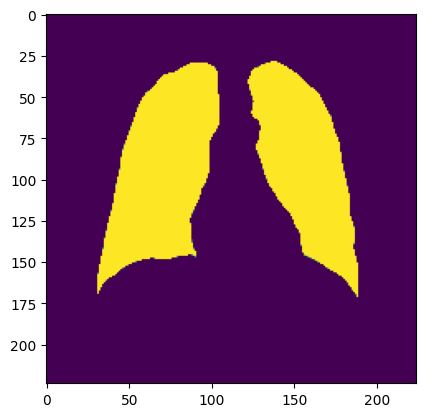

In [42]:
plt.imshow(target[0].squeeze(0).cpu().numpy())

In [43]:
!pip install segmentation-models-pytorch


In [44]:
import segmentation_models_pytorch as smp
model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    #encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
).cuda()

In [45]:
def dice_loss(pred, target):
    # Apply sigmoid to convert logits to probabilities
    pred = torch.sigmoid(pred)

    # Flatten predictions and targets
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)

    # Calculate intersection and sums
    intersection = (pred_flat * target_flat).sum()
    pred_sum = pred_flat.sum()
    target_sum = target_flat.sum()

    # Compute Dice coefficient and return Dice loss
    dice = (2. * intersection + 1e-5) / (pred_sum + target_sum + 1e-5)
    return 1 - dice


In [46]:
import torch.optim as optim

criterion = dice_loss
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)


In [47]:
losses = []
vlosses = []

In [48]:

iter_num = 0
n_epoch = 50
start_time = time.time()

for epoch_num in range(n_epoch):
    loss_ = []
    vloss_ = []
    for i_batch, sampled_batch in enumerate(train_loader):
        image_batch, label_batch = sampled_batch
        image_batch = image_batch.float()
        image_batch, label_batch = image_batch.cuda(), label_batch.cuda()
        outputs = model(image_batch)
        outputs = torch.squeeze(outputs, 1)
        loss = criterion(outputs, label_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    losses.append(np.mean(loss_,axis = 0))
    print('train epoch ',epoch_num)
    print('-------- train dice ce total', np.mean(loss_,axis = 0))
    with torch.no_grad():
        for i_batch, sampled_batch1 in enumerate(val_loader):
            image_batch1, label_batch1 = sampled_batch1
            image_batch1 = image_batch1.float()
            image_batch1, label_batch1 = image_batch1.cuda(), label_batch1.cuda()
            outputs1 = model(image_batch1)
            outputs1 = torch.squeeze(outputs1, 1)
            vloss = criterion(outputs1, label_batch1.float())
            vloss_.append(vloss.item())
        vlosses.append(np.mean(vloss_,axis = 0))
        print('-------- test loss ', np.mean(vloss_,axis = 0))
end_time = time.time()

train epoch  0
-------- train dice ce total 0.1931839073803408
-------- test loss  0.05875746077961392
train epoch  1
-------- train dice ce total 0.04720623273376032
-------- test loss  0.051922298139996
train epoch  2
-------- train dice ce total 0.03728742379668756
-------- test loss  0.05105717976888021
train epoch  3
-------- train dice ce total 0.032319652273299845
-------- test loss  0.04737162093321482
train epoch  4
-------- train dice ce total 0.030120484795130735
-------- test loss  0.04830813242329492
train epoch  5
-------- train dice ce total 0.028489577432050772
-------- test loss  0.04482404390970866
train epoch  6
-------- train dice ce total 0.025716868698174227
-------- test loss  0.04500601854589251
train epoch  7
-------- train dice ce total 0.023623661369296677
-------- test loss  0.045164725846714444
train epoch  8
-------- train dice ce total 0.022705872008141052
-------- test loss  0.045668130119641624
train epoch  9
-------- train dice ce total 0.0213110294747

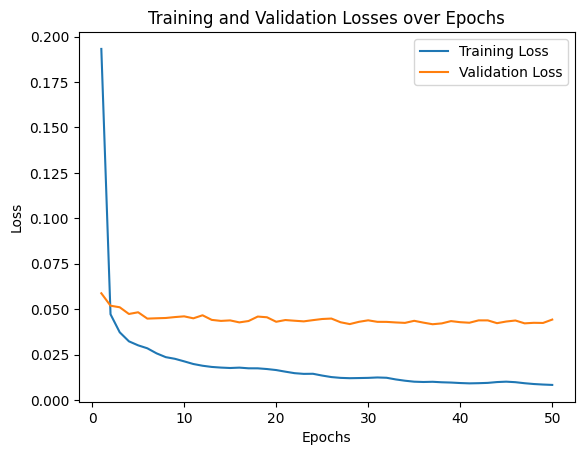

In [49]:
# Create a range of epochs for x-axis
epochs = range(1, len(losses) + 1)

# Plot training and validation losses on the same graph
plt.plot(epochs, losses, label='Training Loss')
plt.plot(epochs, vlosses, label='Validation Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses over Epochs')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [50]:
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [51]:
d = []

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [77]:
def one_mask(img, threshold=0.5):
    """
    Given an input image (as a numpy array or tensor), process it through the model to obtain a predicted mask.

    Parameters:
        img (numpy.array or torch.Tensor): The input image.
        threshold (float): Threshold to binarize the predicted mask.

    Returns:
        tuple: (processed_image, mask_pred)
            processed_image: The input image as a numpy array.
            mask_pred: The predicted mask as a numpy array.
    """

    # If img is a numpy array, convert it to a tensor
    if isinstance(img, np.ndarray):
        tensor_img = torch.tensor(img, dtype=torch.float32)
    else:
        tensor_img = img.float()

    # If the image is 2D (H, W), add channel and batch dimensions: shape becomes (1, 1, H, W)
    if tensor_img.ndim == 2:
        tensor_img = tensor_img.unsqueeze(0).unsqueeze(0)
    # If the image is 3D (C, H, W) but missing batch, add batch dimension.
    elif tensor_img.ndim == 3:
        tensor_img = tensor_img.unsqueeze(0)

    # Move the image to the same device as your model
    tensor_img = tensor_img.to(device)

    # Set model to evaluation mode and perform inference
    model.eval()
    with torch.no_grad():
        outputs = model(tensor_img)
        # Assuming the model outputs a tensor of shape [batch, channels, H, W]
        # For a single image with one output channel, remove the batch and channel dimensions
        outputs = outputs.squeeze(0).squeeze(0)  # Now shape should be [H, W]
        # Apply sigmoid if the model output is logits
        mask_prob = torch.sigmoid(outputs)
        # Convert probabilities to a binary mask using the given threshold
        mask_pred = (mask_prob > threshold).float().cpu().numpy()

    # Convert the original image to a numpy array for visualization.
    # If tensor_img was converted from a numpy array, convert it back (remove batch and channel dims)
    processed_image = tensor_img.cpu().detach().numpy()
    processed_image = processed_image.squeeze()  # Remove extra dimensions

    return processed_image, mask_pred


In [78]:
img, mask = one_mask(X_test[0])

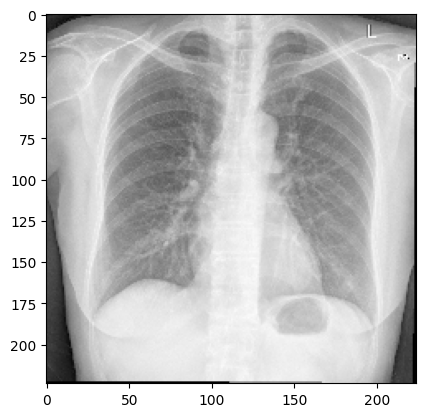

In [80]:
plt.imshow(img, cmap="gray")


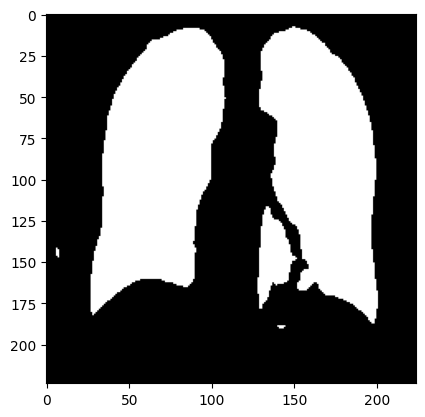

In [82]:
plt.imshow(mask, cmap="gray")

In [83]:
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [89]:
import numpy as np

def calculate_dice_coefficient(mask_true, mask_pred, threshold=0.5):
    """
    Calculate the Dice coefficient between the ground truth mask and the predicted mask.
    Both masks are assumed to be numpy arrays with values in [0, 1].
    """
    # Convert masks to binary (boolean) arrays using the given threshold
    mask_true_bin = mask_true.astype(bool)
    mask_pred_bin = (mask_pred > threshold)

    # Compute the intersection
    intersection = np.logical_and(mask_true_bin, mask_pred_bin).sum()

    # Compute the sums of each mask (adding a small epsilon to avoid division by zero)
    dice_coefficient = (2. * intersection) / (mask_true_bin.sum() + mask_pred_bin.sum() + 1e-5)
    return dice_coefficient


def precision_score(groundtruth_mask, pred_mask, threshold=0.5):
    gt_bin = groundtruth_mask.astype(bool)
    pred_bin = (pred_mask > threshold)

    tp = np.logical_and(gt_bin, pred_bin).sum()
    fp = np.logical_and(~gt_bin, pred_bin).sum()
    precision = tp / (tp + fp + 1e-5)
    return round(precision, 3)


def recall_score(groundtruth_mask, pred_mask, threshold=0.5):
    gt_bin = groundtruth_mask.astype(bool)
    pred_bin = (pred_mask > threshold)

    tp = np.logical_and(gt_bin, pred_bin).sum()
    fn = np.logical_and(gt_bin, ~pred_bin).sum()
    recall = tp / (tp + fn + 1e-5)
    return round(recall, 3)


def calculate_iou(mask_true, mask_pred, threshold=0.5):
    mask_true_bin = mask_true.astype(bool)
    mask_pred_bin = (mask_pred > threshold)

    intersection = np.logical_and(mask_true_bin, mask_pred_bin).sum()
    union = np.logical_or(mask_true_bin, mask_pred_bin).sum()
    iou = intersection / (union + 1e-5)
    return iou

from scipy.spatial.distance import directed_hausdorff

def hausdorff_distance(mask1, mask2, threshold=0.5):
    # Convert to binary masks
    mask1_bin = (mask1 > threshold)
    mask2_bin = (mask2 > threshold)

    # Get coordinates of non-zero (foreground) pixels
    coords1 = np.column_stack(np.where(mask1_bin))
    coords2 = np.column_stack(np.where(mask2_bin))

    # If one of the masks is empty, you can choose to return np.nan or a large value
    if coords1.size == 0 or coords2.size == 0:
        return np.nan

    # Compute the directed Hausdorff distance in both directions
    d1 = directed_hausdorff(coords1, coords2)[0]
    d2 = directed_hausdorff(coords2, coords1)[0]

    return max(d1, d2)


In [90]:
dice = []
hd = []
prec = []
rec = []
iou = []
for ind,img in tqdm.tqdm(enumerate(X_test)):
    _,mask_pred = one_mask(img)
    mask_true = y_test[ind]
    dice.append(calculate_dice_coefficient(mask_true, mask_pred))
    hd.append(hausdorff_distance(mask_true, mask_pred[0][0]))
    prec.append(precision_score(mask_true, mask_pred))
    rec.append(recall_score(mask_true, mask_pred))
    iou.append(calculate_iou(mask_true, mask_pred))

0it [00:00, ?it/s]<ipython-input-89-b52198abb0a5>:58: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  coords2 = np.column_stack(np.where(mask2_bin))
141it [00:01, 75.37it/s]


In [86]:
print(np.mean(hd))
print(np.mean(dice))
print(np.mean(iou))
print(np.mean(prec))
print(np.mean(rec))


nan
nan
nan
nan
nan


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
